# **Problem Statement:**
The goal is to predict whether a customer will churn (i.e., stop using a service) based on their behavioral and transactional data. Churn prediction is crucial for businesses to retain customers and reduce revenue loss. By identifying customers who are likely to churn, businesses can take proactive measures to improve customer retention.

# **Problem Definition:**
Develop a classification model using the Telco Customer Churn dataset from Kaggle to predict customer churn. The model should analyze various features such as usage frequency, account age, transaction amounts, and other relevant numerical data. The primary objective is to apply machine learning techniques like Support Vector Machines (SVM), Gradient Boosting, and XGBoost to classify customers into two categories: those who will churn and those who will not. The model's performance will be evaluated using metrics such as accuracy, precision, recall, and the ROC-AUC score, with hyperparameter tuning conducted via cross-validation to optimize the results.

This problem aims to enhance the understanding and application of feature engineering, data preprocessing, classification algorithms, and model tuning in a real-world scenario.

# Imports and Libraries :

In [59]:
import warnings
warnings.filterwarnings("ignore")
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
import joblib

# Prepare some functions to use :

##### 1- Function to get the all values of each column

In [2]:
def GetValuesCounts(data):
    import pandas as pd
    columns = [col for col in data.columns ]

    for col in columns:
        print(data[col].value_counts(),"\n")

##### 2- Function to get the object (string) Features 

In [3]:
def GetObjectFeatures(data) :
    object_columns = [col for col in data.columns if data[col].dtype == 'object']

    for col in object_columns :
        print(data[col].value_counts(),"\n")

##### 3- Function to "Plot Box Plot" and it works only for the datatype of integer and float columns .

In [4]:
def PBP (data):
    for col in data.select_dtypes(include=['int', 'float']).columns:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title(f'Boxplot of {col}')
        bp=data.boxplot(column=col)
        plt.show()
        plt.close(fig)

##### 4- Function to Plot Pair Plot with different Hues

In [5]:
def TribleP(data):
    columns = [col for col in data.columns]
    custom_palette = sns.color_palette("coolwarm", 6)

    for col in columns:
        if data[col].value_counts().count() <= 6:
            sns.pairplot(data, hue=col, palette=custom_palette)
            plt.show()
        else:
            continue

##### 5- Function to Plot Distribution Plot 

In [6]:
def PDP(data):
    columns = [col for col in data.columns]
    colors = sns.color_palette("coolwarm", len(columns))
    
    for i, col in enumerate(data.select_dtypes(include=['int', 'float']).columns):
        if data[col].value_counts().count() <= 10000:
            sns.histplot(data[col], kde=True, bins=15, color=colors[i % len(colors)])
            plt.title(f'Distribution of {col}')
            plt.show()

##### 6- Function to Plot Pie chart if the feature has values less than or equal 10

In [7]:
def PlotPie(data):
    custom_palette = "coolwarm"
    sns.set_palette(custom_palette)
    

    plt.figure(figsize=(8, 6))
    
    columns = [col for col in data.columns]
    
    for col in columns:
        if data[col].value_counts().count() <= 10:
            # Plot pie chart
            plt.figure(figsize=(8,6))
            data[col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
            plt.title(f"Distribution of {col}")
            plt.ylabel("")
            plt.axis('equal')  
            plt.show()
            print("\n\n\n")

##### 7- Function to Plot Confusion Matrix for List of Models 

In [8]:
def plot_confusion_matrix_custom(y_test, y_pred , models):
    
    CM = confusion_matrix(y_test, y_pred)
    print(CM)
    sns.heatmap(CM, annot=True, cmap="coolwarm")
    plt.show()


##### 8- Function to train and Evaluate list of Models 

In [63]:
def TrainEvaluateModel(X_train, y_train, X_test, y_test , models):
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'{model_name} Accuracy: {accuracy}')
        
        plot_confusion_matrix_custom(y_test, y_pred,models)
        
        print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_pred, multi_class='ovo'):.4f}",)
        print("\n")
        
        print(f'Classification Report for {model_name}:\n')
        print(classification_report(y_test, y_pred))
        print('\n' + '-'*60 + '\n')

##### 9- Function to plot the features importances 

In [10]:
def PlotFeaturesImportance(X, y, models):
    feature_importances = {}

    for name, model in models.items():
        model.fit(X, y)
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = None
        if importances is not None:
            feature_importances[name] = importances

    # Convert to DataFrame for easier plotting way with the barchart
    feature_importances_df = pd.DataFrame(feature_importances, index=X.columns)

    # Plot  each feature importance
    feature_importances_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.legend(title='Model')
    plt.show()

##### 10- Function to plot the validation and training score 

In [11]:
def PlotOverfitting(models,X_train,X_val,y_train,y_val,metric=accuracy_score):
    train_scores = []
    val_scores = []
    model_names = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_score = metric(y_train, y_train_pred)
        val_score = metric(y_val, y_val_pred)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        model_names.append(name)

    x = range(len(model_names))
    plt.figure(figsize=(12, 6))
    plt.plot(x, train_scores, label='Training Score', marker='|')
    plt.plot(x, val_scores, label='Validation Score', marker='x')
    plt.xticks(x, model_names, rotation=45)
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Training vs Validation Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()



##### 11- Function to save all Models as SAV Files 

In [12]:
def SaveModels (models, base_filename="Models"):
    for name, model in models.items():
        filename = f"{base_filename} - {name}.sav"
        joblib.dump(model, filename)
        print(f"Model '{name}' saved as '{filename}'.")

# Reading Data :

In [13]:
data = pd.read_csv("/kaggle/input/telecom-customers/Telecom Customers Churn.csv")
copiedData = copy.deepcopy(data)

# EDA :

In [14]:
data.head(7)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  

[7 rows x 21 columns]

In [15]:
data.tail(7)

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
7036  7750-EYXWZ  Female              0      No         No      12   
7037  2569-WGERO  Female              0      No         No      72   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
7036           No  No phone service             DSL                   No  ...   
7037          Yes                No              No  No internet service  ...   
7038          Yes               Yes             DSL                  Yes  ...   
7039          Yes               Yes     Fiber optic                   No  ...   
7040           No  No phone service             DSL                  Yes  ...   
7041          Yes               Yes     Fiber optic                   No  ...   
7042          Yes                No     Fiber optic                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
7036                  Yes                  Yes                  Yes   
7037  No internet service  No internet service  No internet service   
7038                  Yes                  Yes                  Yes   
7039                  Yes                   No                  Yes   
7040                   No                   No                   No   
7041                   No                   No                   No   
7042                  Yes                  Yes                  Yes   

          StreamingMovies        Contract PaperlessBilling  \
7036                  Yes        One year               No   
7037  No internet service        Two year              Yes   
7038                  Yes        One year              Yes   
7039                  Yes        One year              Yes   
7040                   No  Month-to-month              Yes   
7041                   No  Month-to-month              Yes   
7042                  Yes        Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges Churn  
7036           Electronic check          60.65         743.3    No  
7037  Bank transfer (automatic)          21.15        1419.4    No  
7038               Mailed check          84.80        1990.5    No  
7039    Credit card (automatic)         103.20        7362.9    No  
7040           Electronic check          29.60        346.45    No  
7041               Mailed check          74.40         306.6   Yes  
7042  Bank transfer (automatic)         105.65        6844.5    No  

[7 rows x 21 columns]

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
data.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [18]:
NumiricalColumns=["SeniorCitizen","tenure","MonthlyCharges"]
for col in NumiricalColumns :
    print("Variance for",col,"column :",data[col].var())

Variance for SeniorCitizen column : 0.13587451579039184
Variance for tenure column : 603.1681081237368
Variance for MonthlyCharges column : 905.4109343405098


In [19]:
for col1 in NumiricalColumns :
    for col2 in NumiricalColumns :
        if (col1==col2):
            continue
        else:
            print("Correlation for",col1,"column with",col2,"column :",data[col].corr(data[col2]))

Correlation for SeniorCitizen column with tenure column : 0.24789985628614994
Correlation for SeniorCitizen column with MonthlyCharges column : 0.9999999999999999
Correlation for tenure column with SeniorCitizen column : 0.22017333857627233
Correlation for tenure column with MonthlyCharges column : 0.9999999999999999
Correlation for MonthlyCharges column with SeniorCitizen column : 0.22017333857627233
Correlation for MonthlyCharges column with tenure column : 0.24789985628614994


In [20]:
for col in NumiricalColumns:
    print("Skewness for", col, "column:", data[col].skew())

Skewness for SeniorCitizen column: 1.8336327440928564
Skewness for tenure column: 0.2395397495619829
Skewness for MonthlyCharges column: -0.22052443394398033


In [21]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [22]:
data.duplicated().sum()

0

In [23]:
GetValuesCounts(data)

customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64 

gender
Male      3555
Female    3488
Name: count, dtype: int64 

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No inte

In [24]:
GetObjectFeatures(data)

customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64 

gender
Male      3555
Female    3488
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection
No                     3095


# Key Points from EDA :

Key Points from Exploration Data Analytics and Statistical Analysis :
1. **Variance:**
   - **SeniorCitizen:** 0.136
   - **Tenure:** 603.17
   - **MonthlyCharges:** 905.41

2. **Correlation:**
   - **SeniorCitizen and Tenure:** 0.25
   - **SeniorCitizen and MonthlyCharges:** 1.00
   - **Tenure and SeniorCitizen:** 0.22
   - **Tenure and MonthlyCharges:** 1.00
   - **MonthlyCharges and SeniorCitizen:** 0.22
   - **MonthlyCharges and Tenure:** 0.25

3. **Skewness:**
   - **SeniorCitizen:** 1.83 (positive skew, indicating a right-skewed distribution)
   - **Tenure:** 0.24 (slightly right-skewed)
   - **MonthlyCharges:** -0.22 (slightly left-skewed)

4. **Data Quality:**
   - No null values or duplicates present.

Based on the analysis:

- The dataset shows **positive skewness** in `SeniorCitizen`, indicating a larger number of non-senior citizens with fewer senior citizens. 
- `Tenure` is slightly right-skewed, suggesting a general trend where most customers have a shorter tenure, but a few have longer tenures.
- `MonthlyCharges` is slightly left-skewed, indicating that most customers pay higher charges, with fewer paying lower amounts.
- **Variance** is highest for `MonthlyCharges`, indicating more variability in charges compared to `SeniorCitizen` and `Tenure`.
- **Correlation** shows a perfect correlation of 1.0 between `SeniorCitizen` and `MonthlyCharges` and between `Tenure` and `MonthlyCharges`, which might be an artifact of how the data was analyzed or represented.

# Visualized EDA :

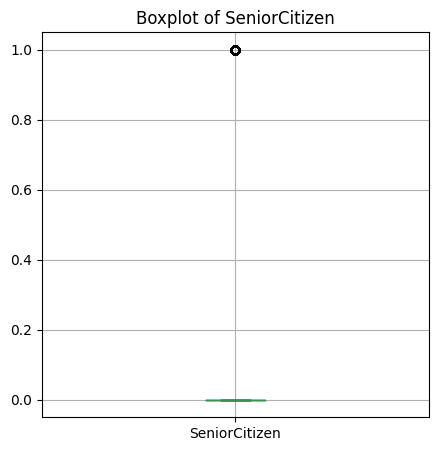

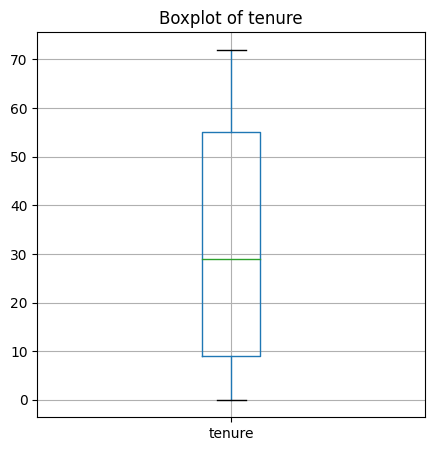

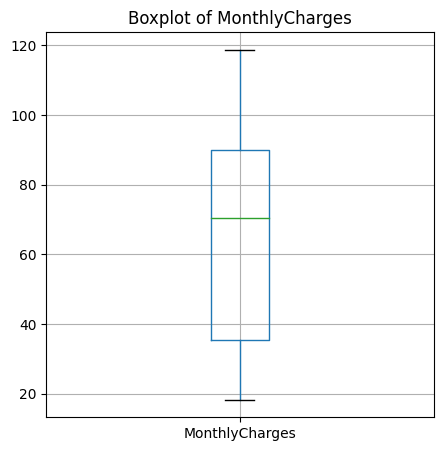

In [25]:
PBP(data)

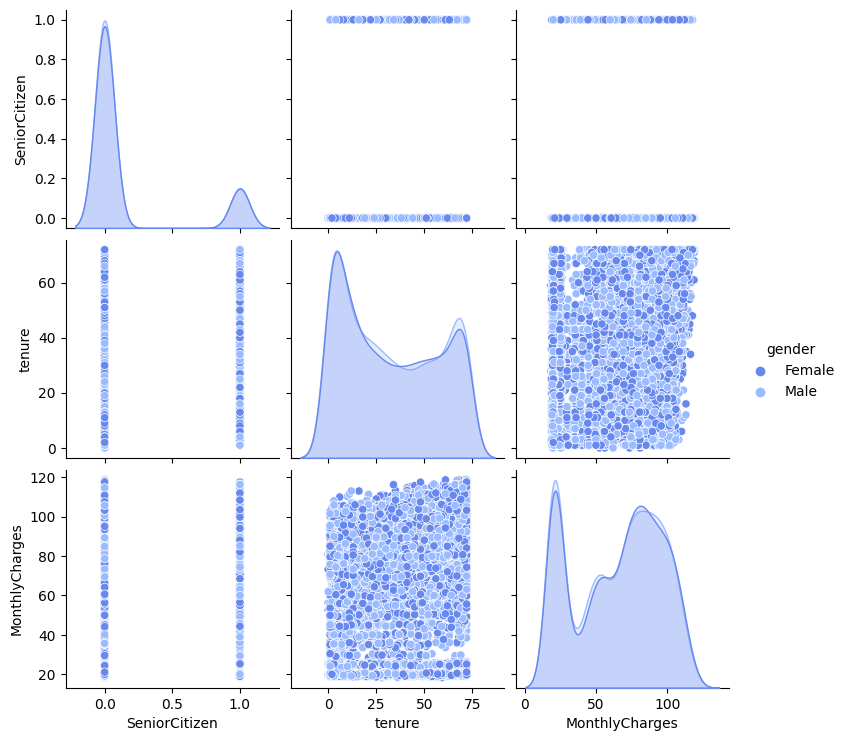

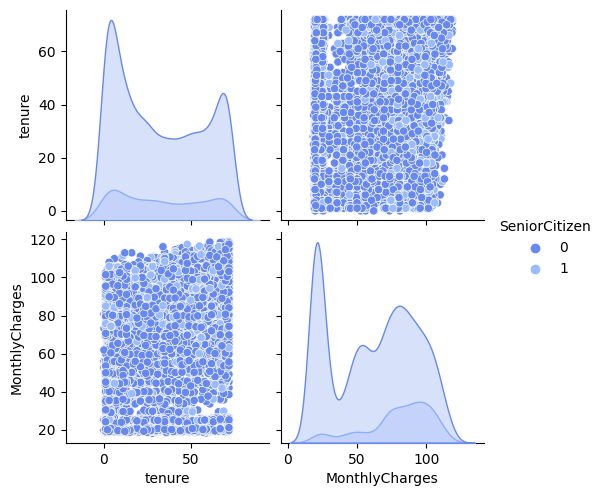

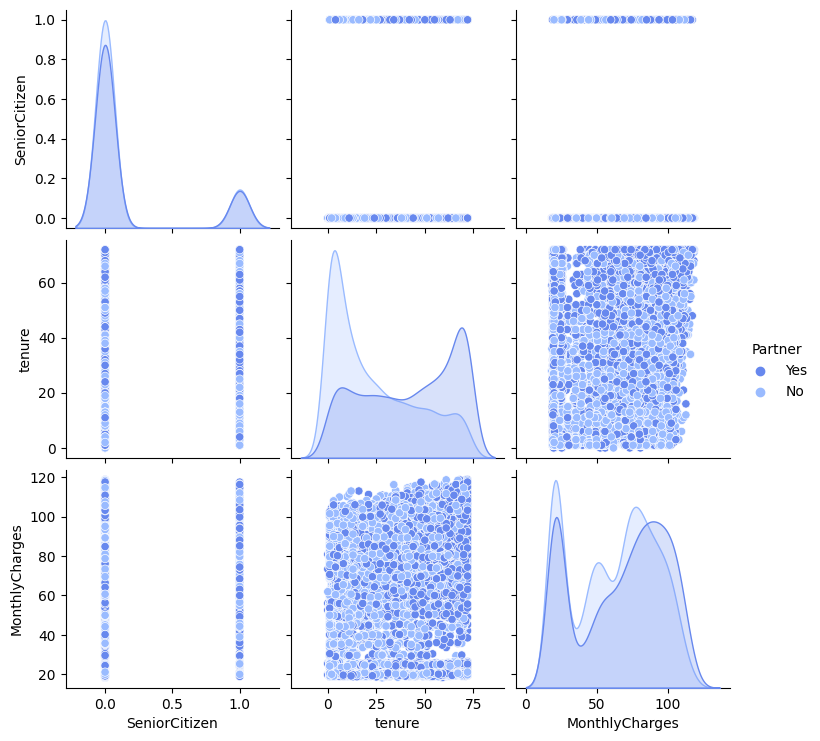

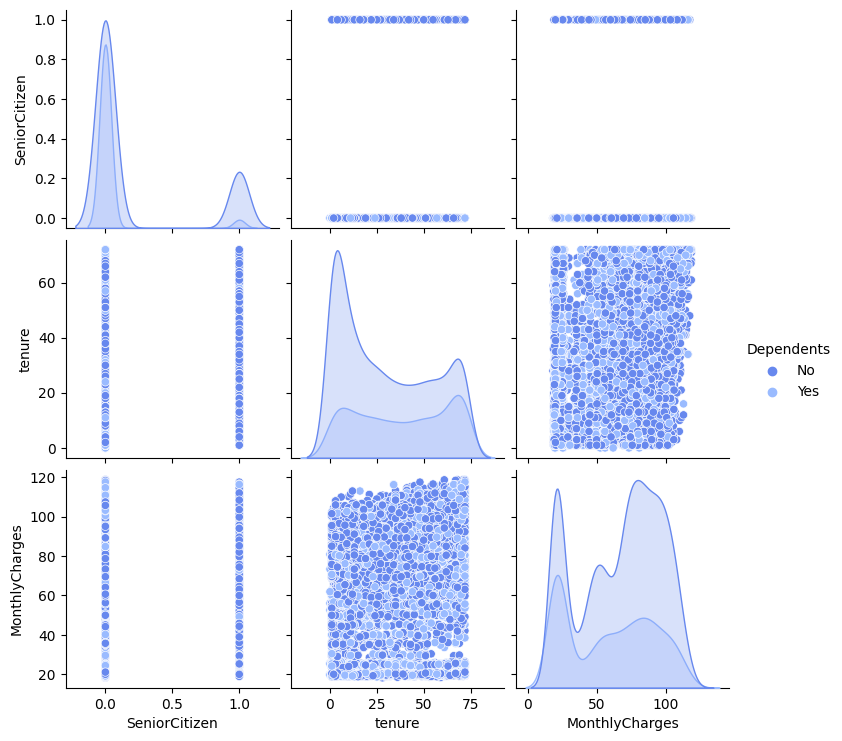

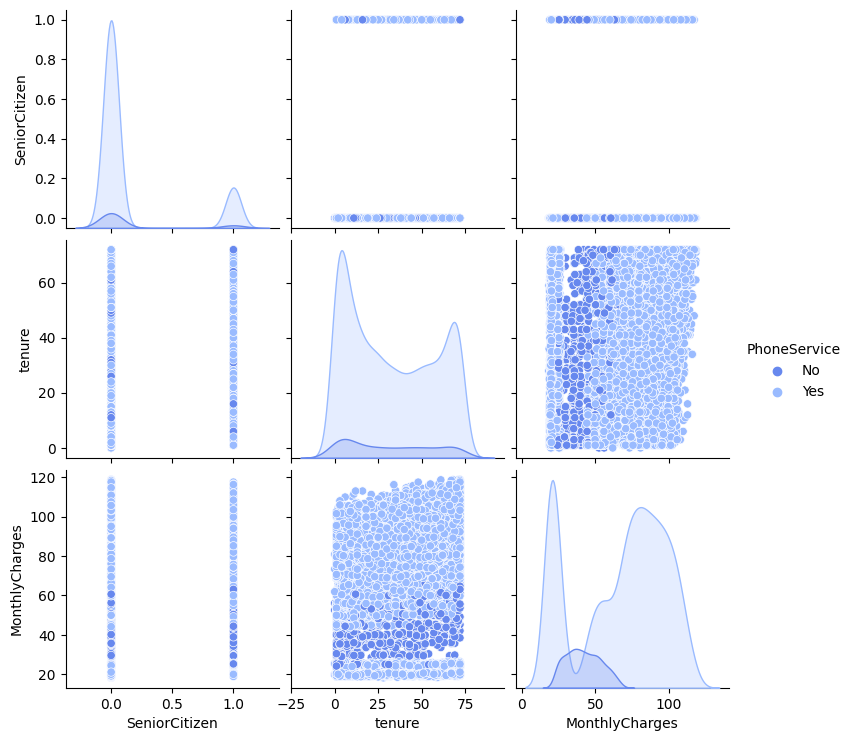

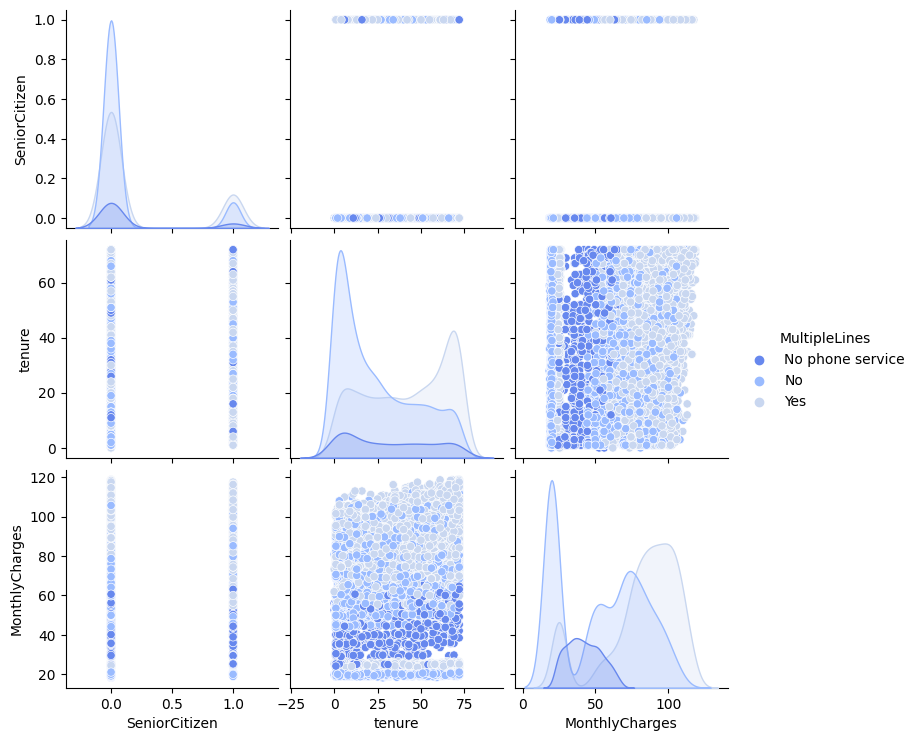

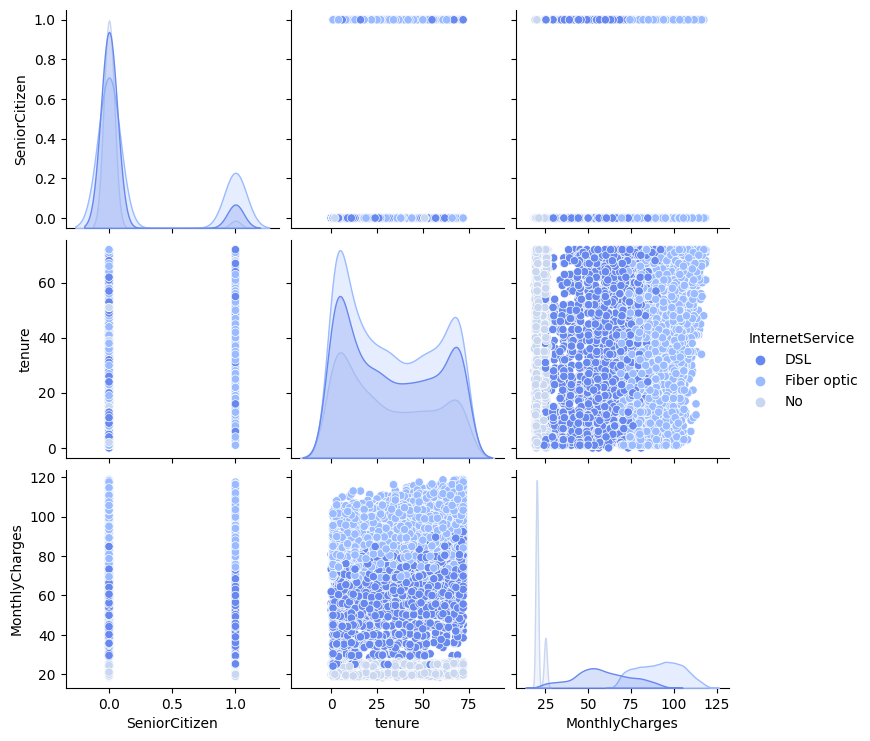

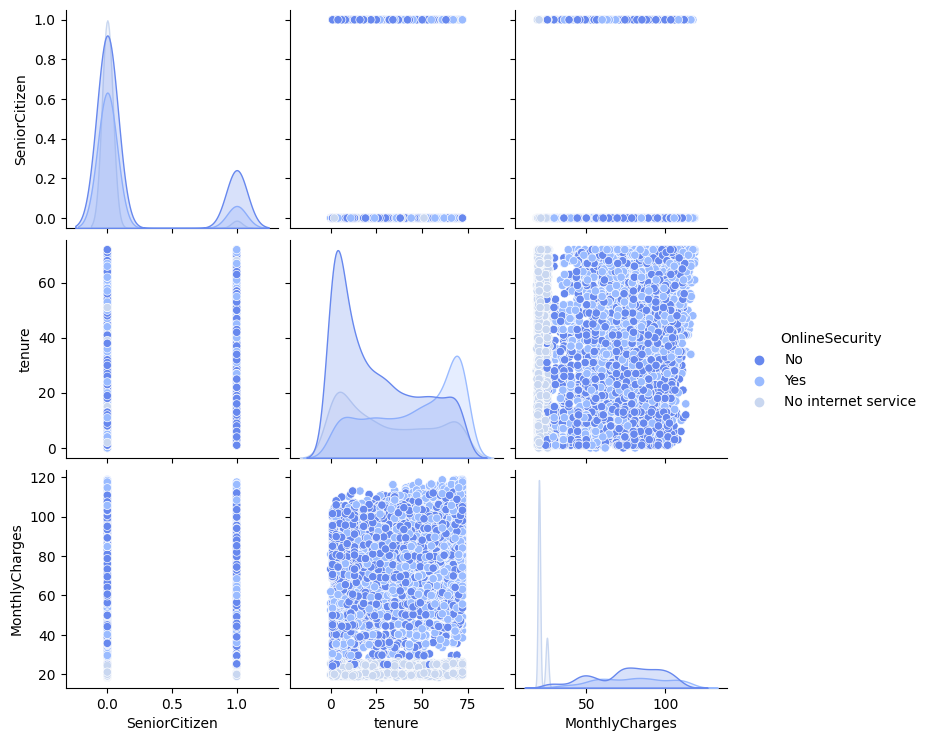

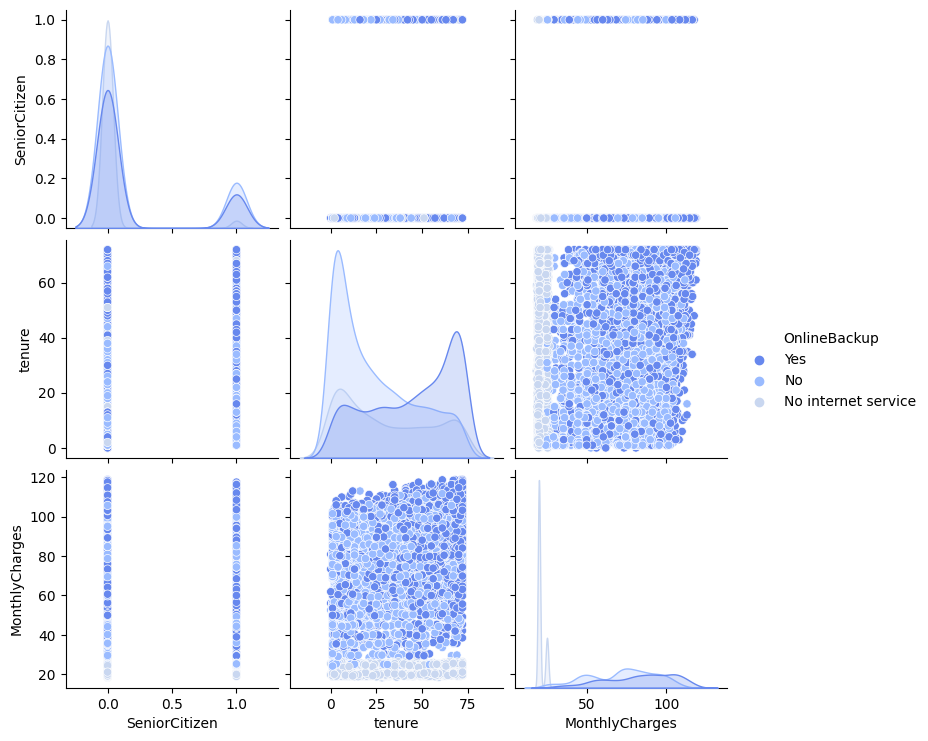

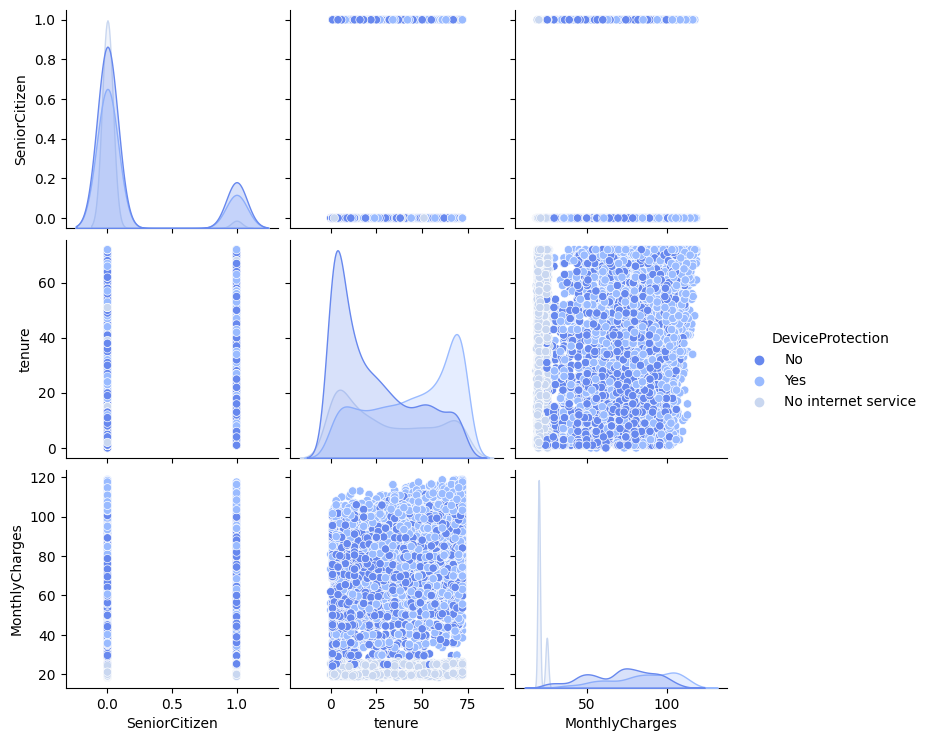

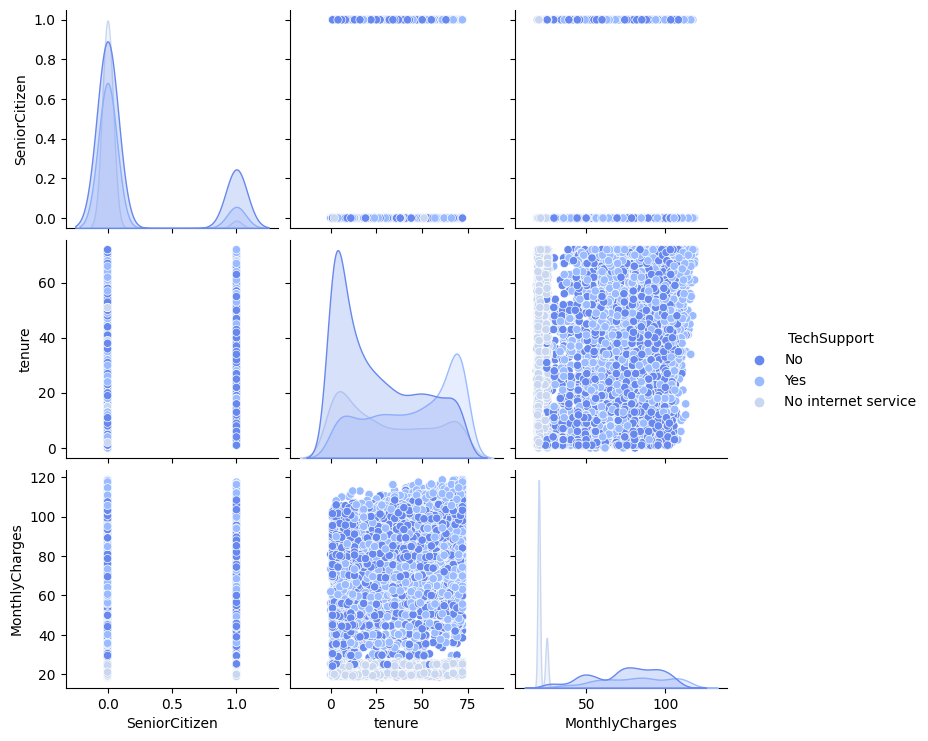

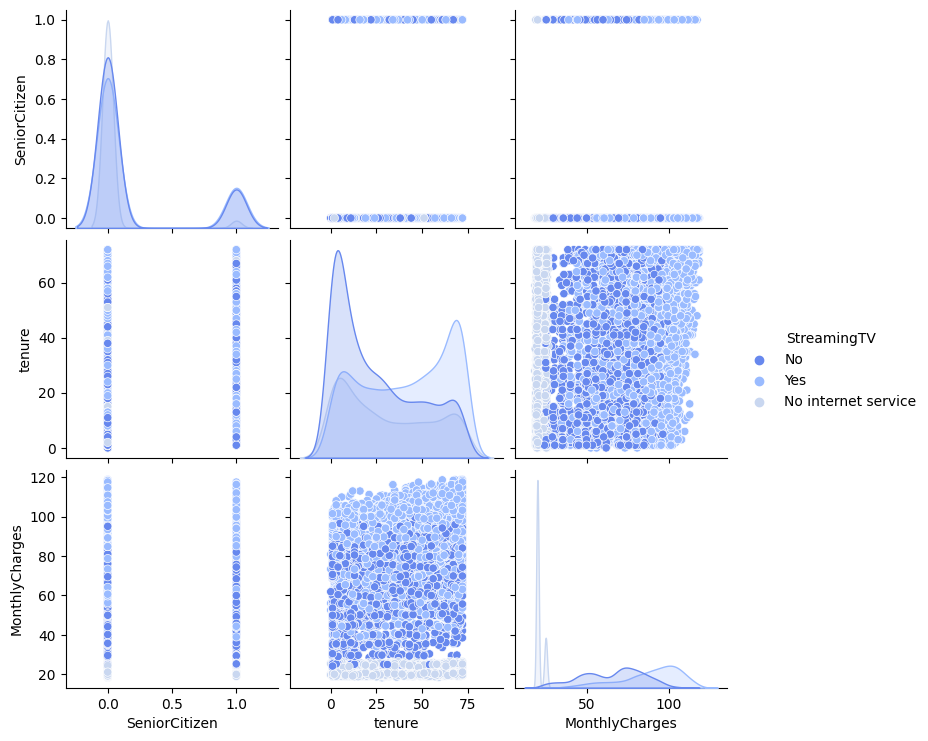

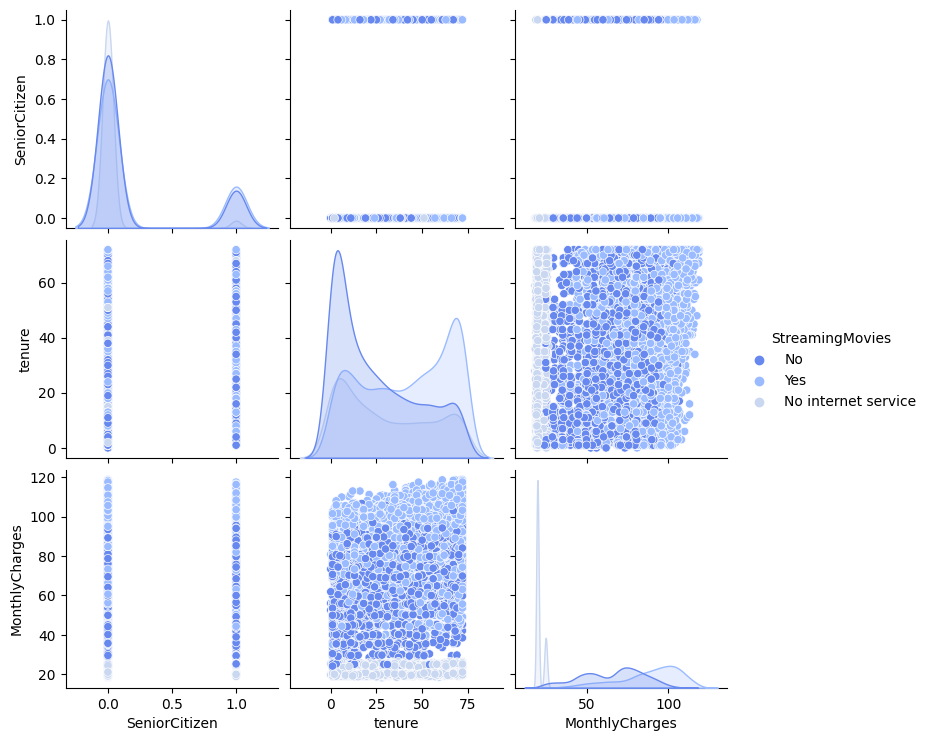

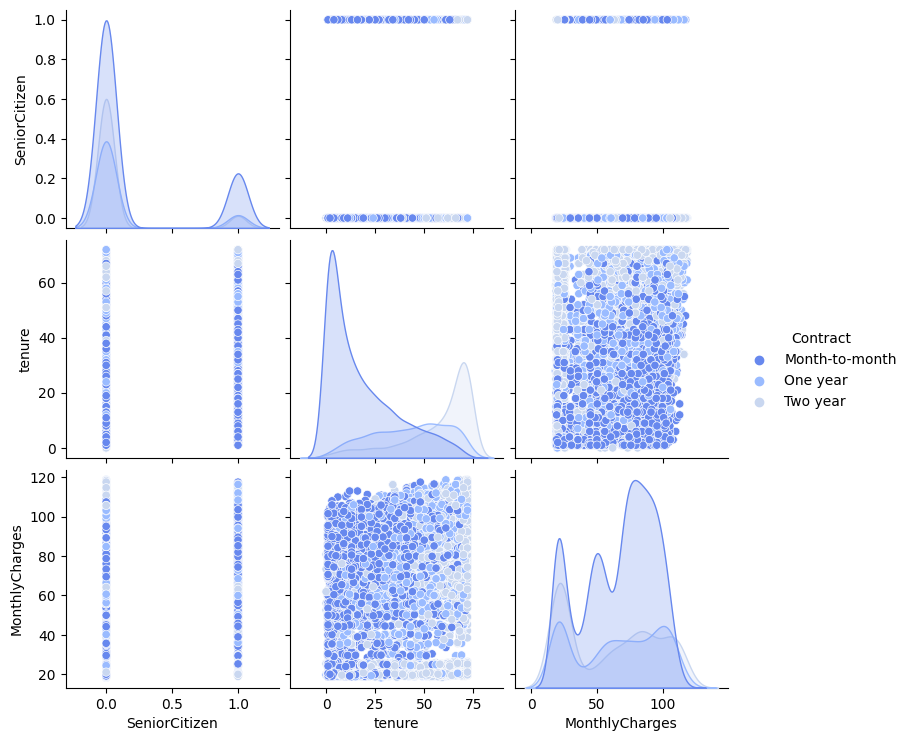

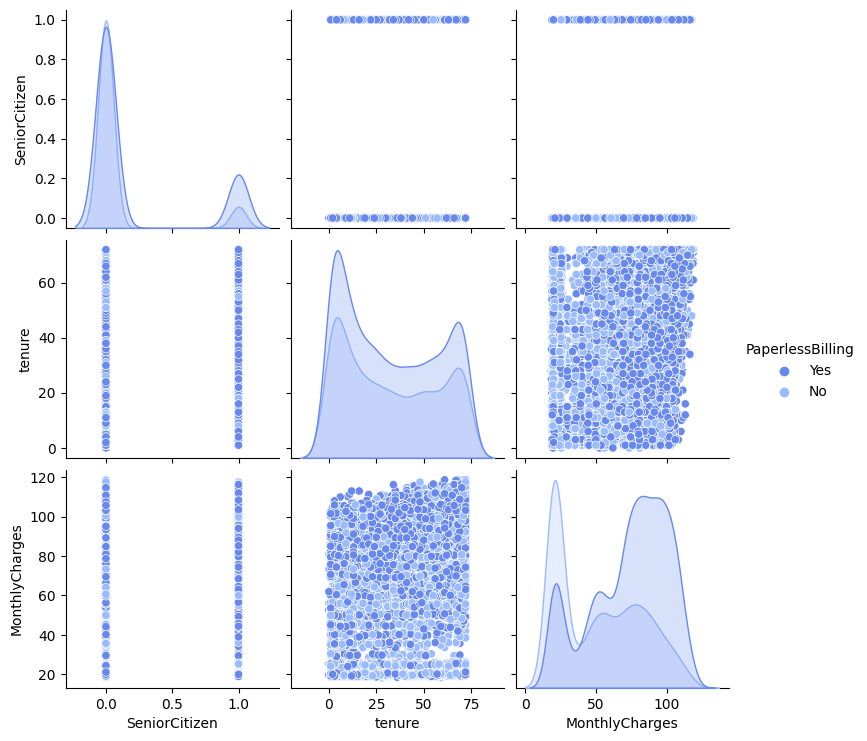

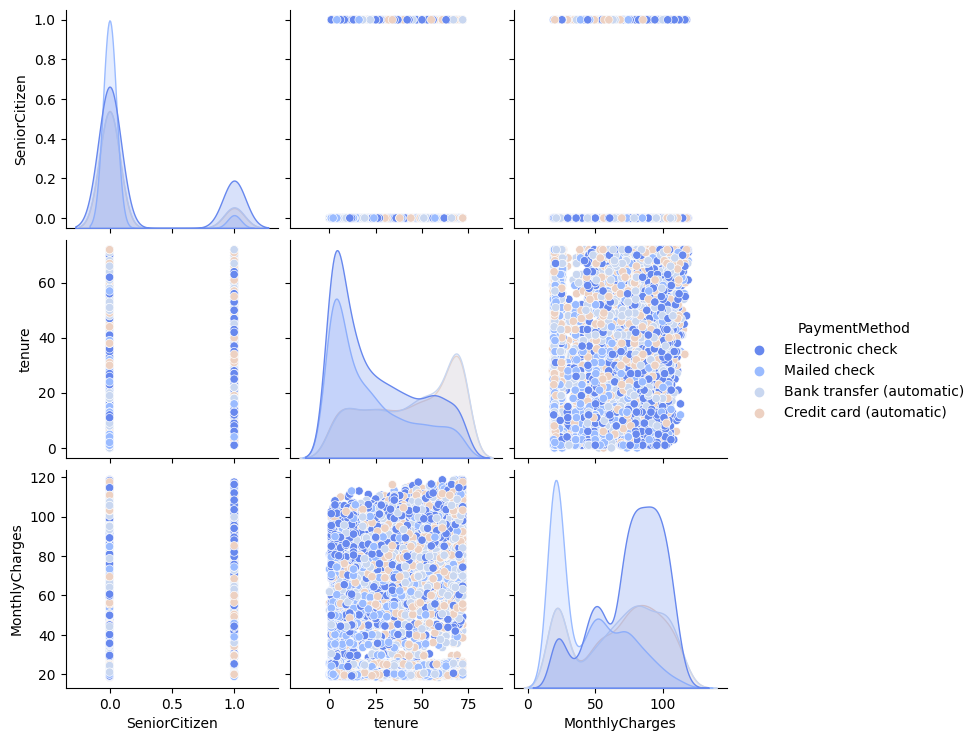

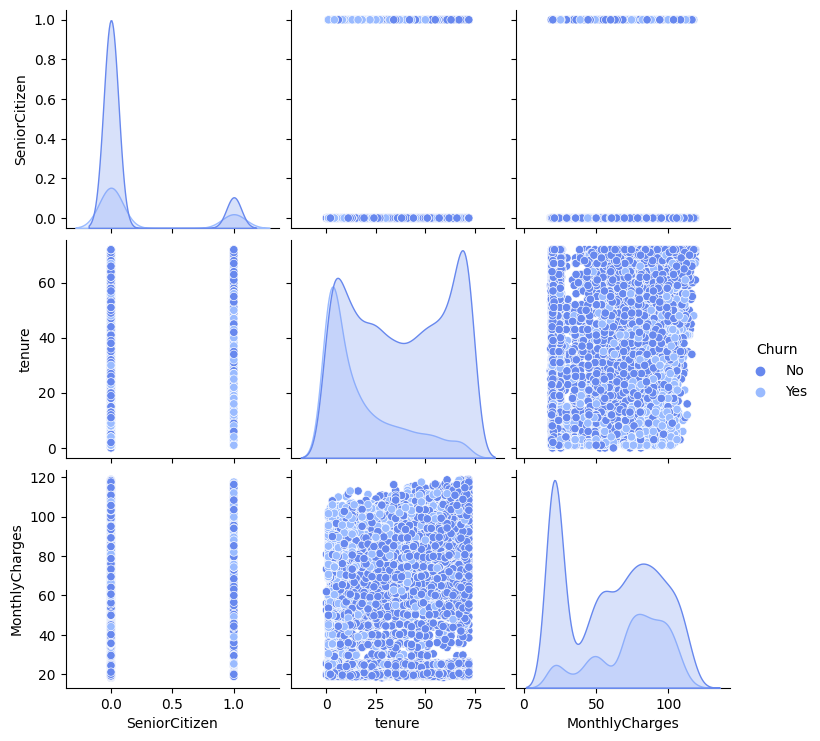

In [26]:
TribleP(data)

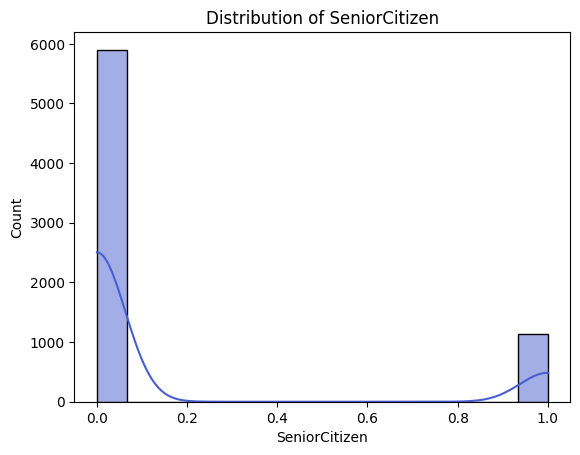

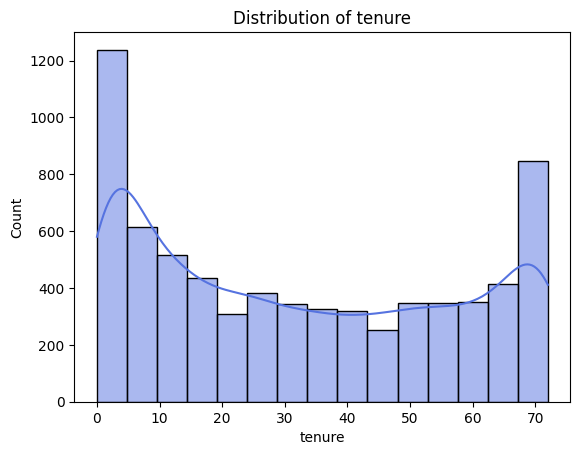

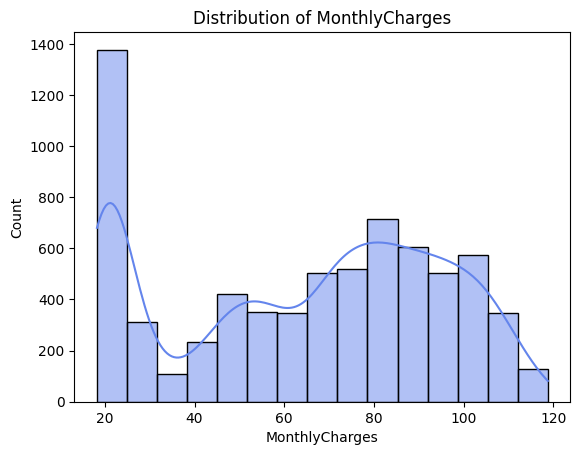

In [27]:
PDP(data)

<Figure size 800x600 with 0 Axes>

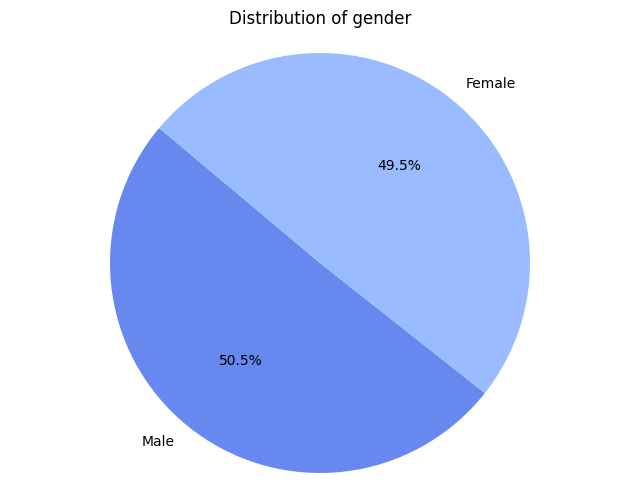

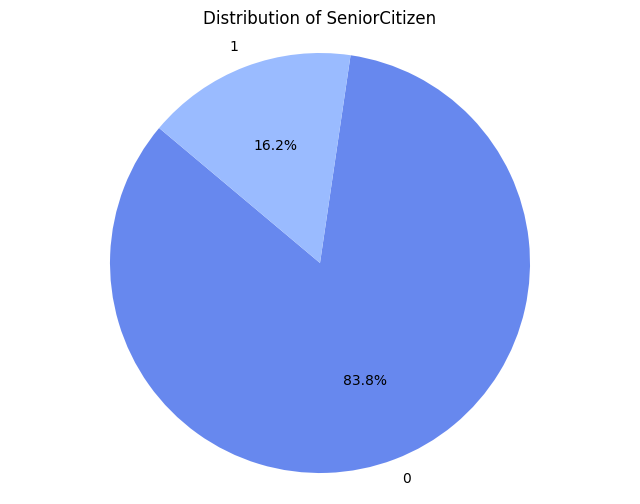

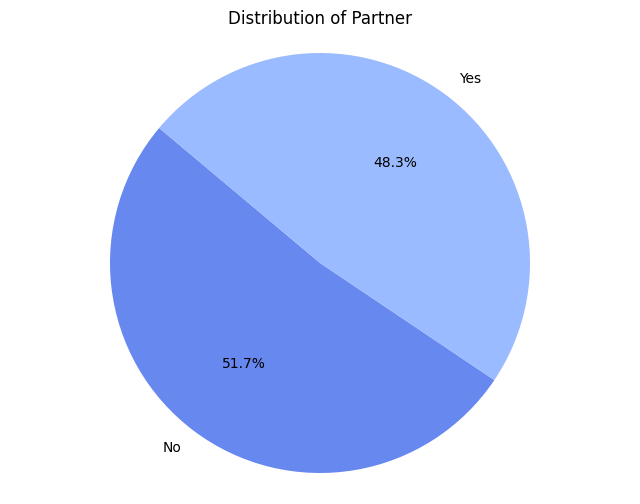

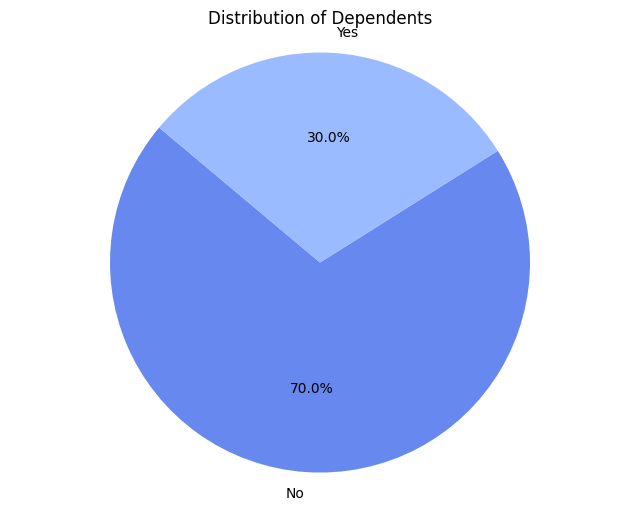

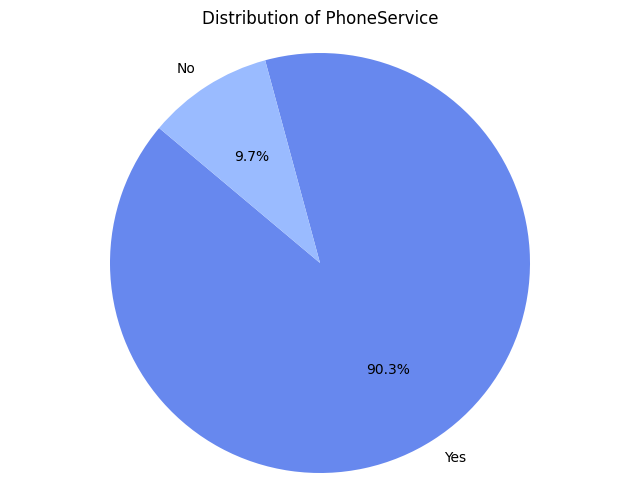

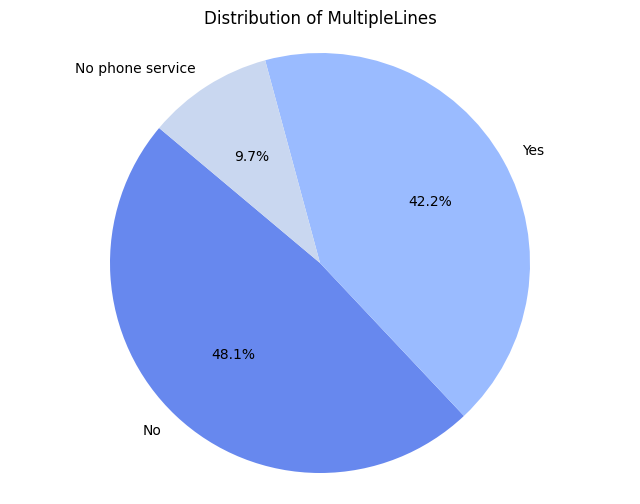

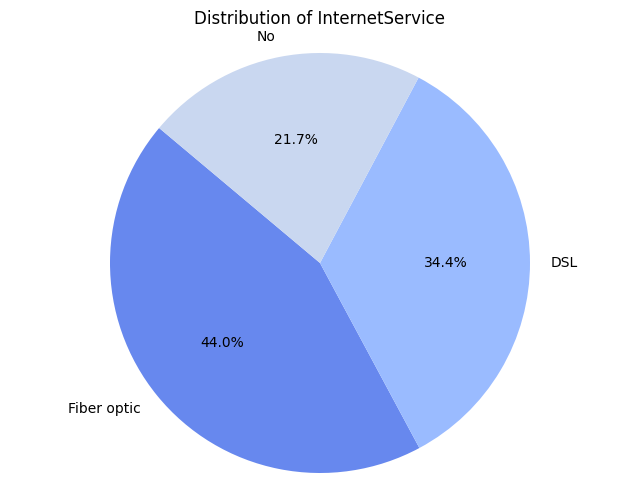

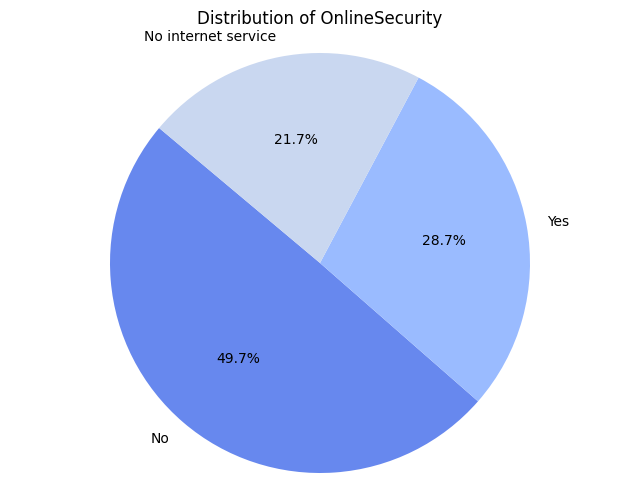

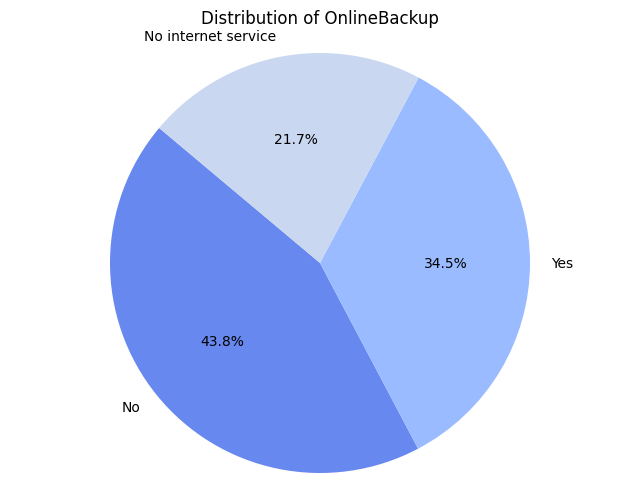

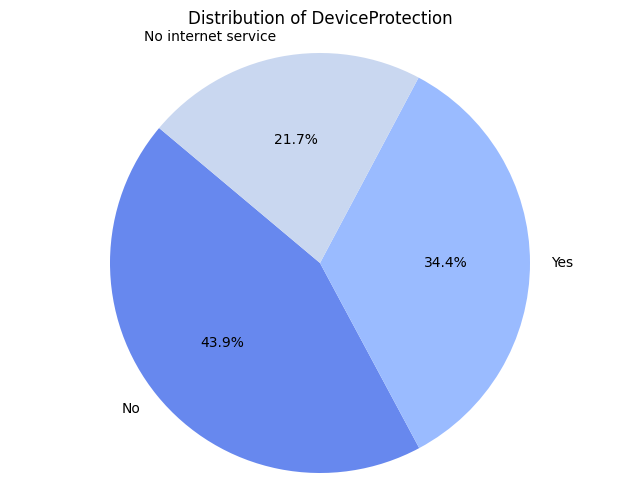

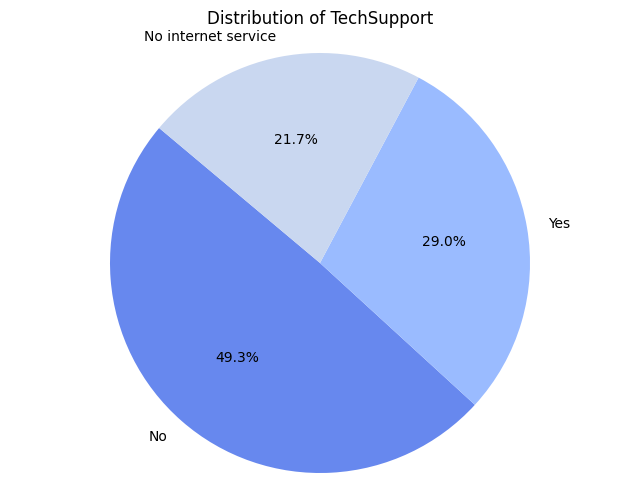

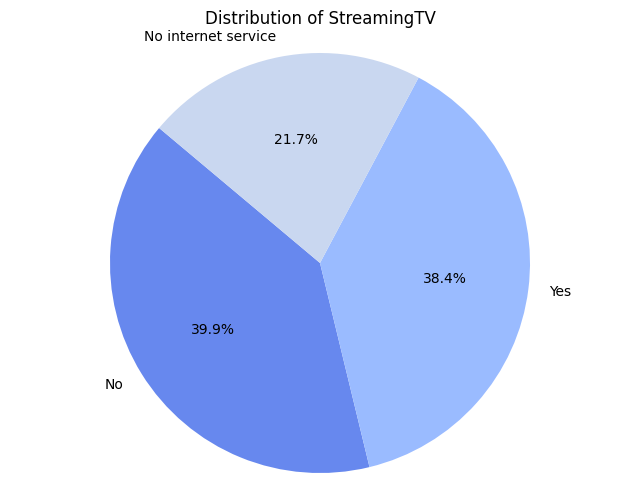

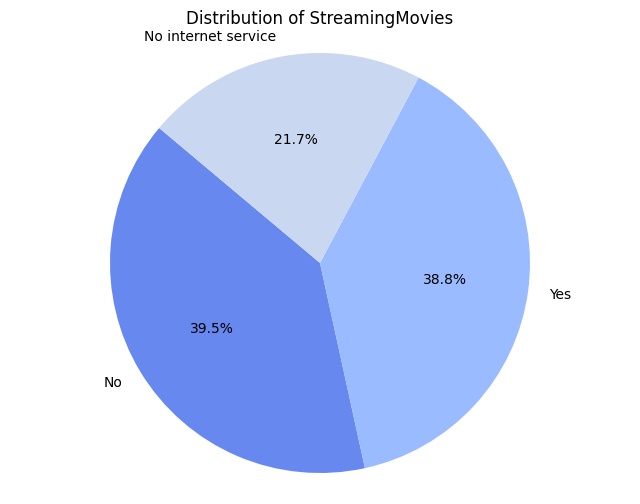

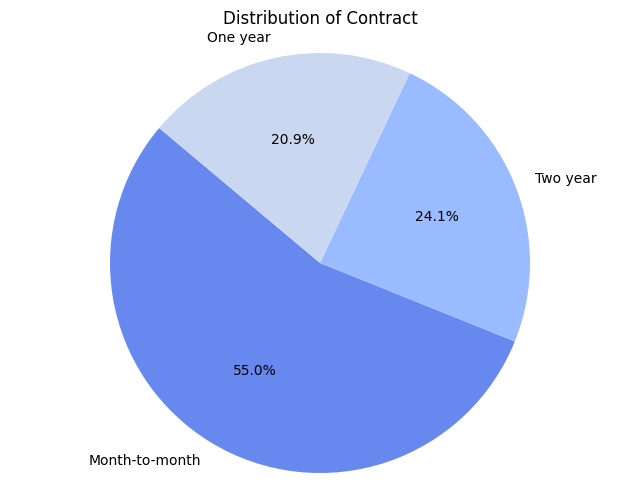

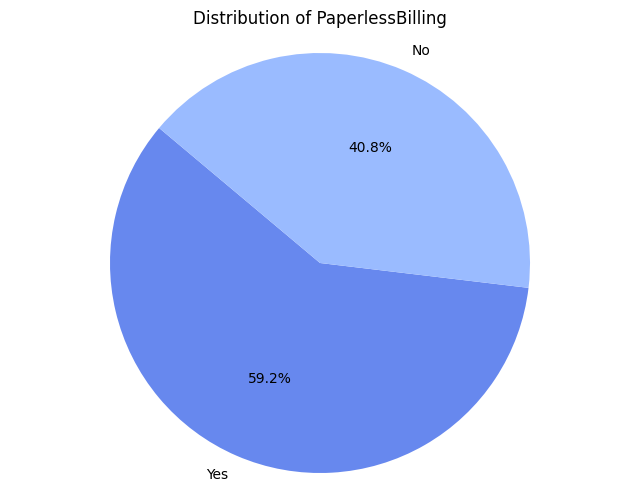

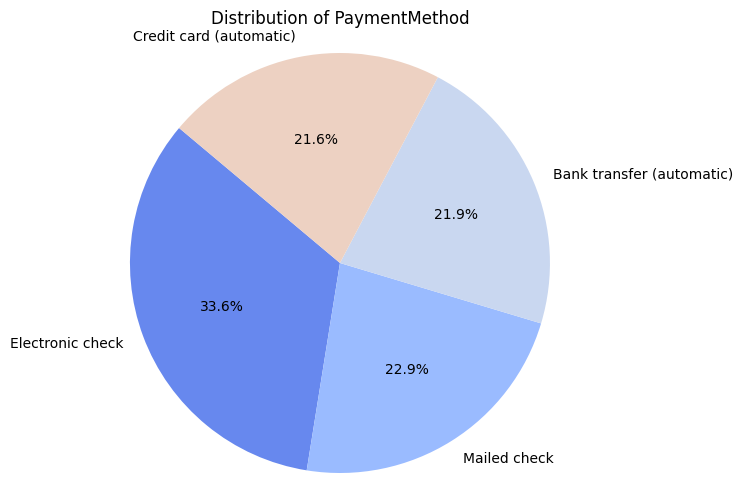

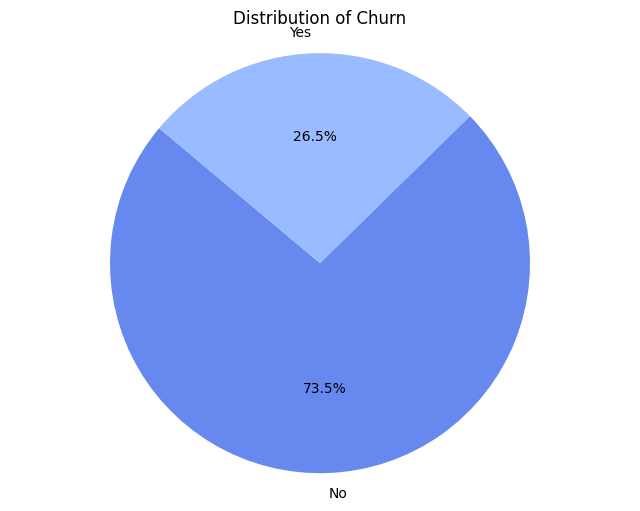

In [28]:
PlotPie(data)

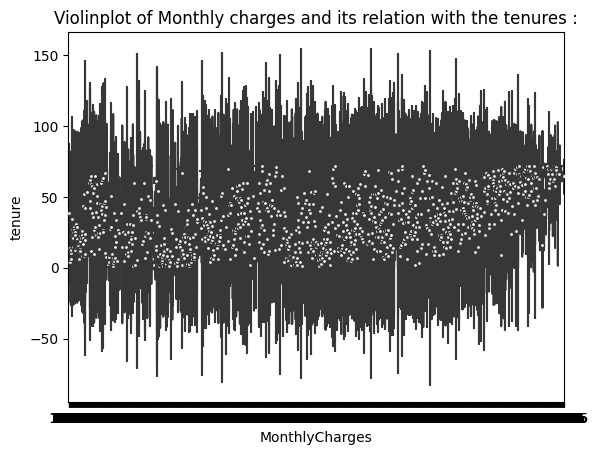

In [28]:
sns.violinplot(x="MonthlyCharges", y='tenure', data=data, palette="coolwarm")
plt.title('Violinplot of Monthly charges and its relation with the tenures :')
plt.show()

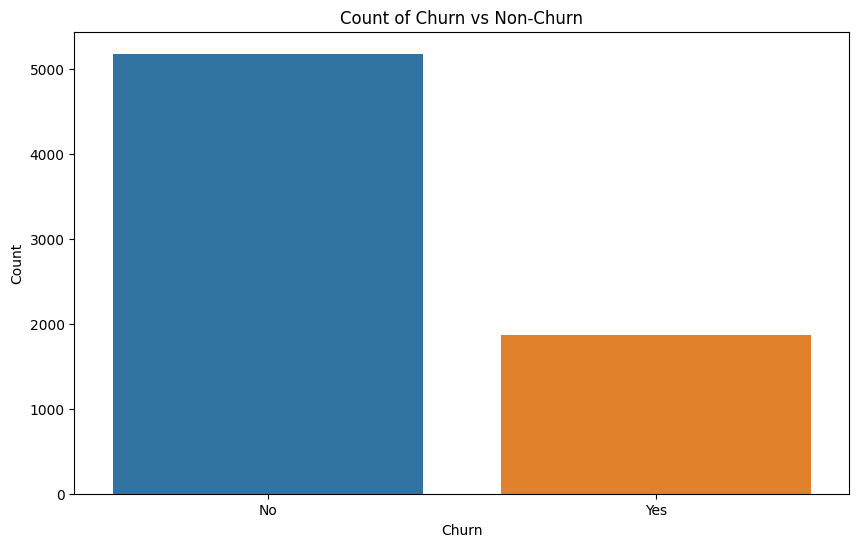

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=data)
plt.title('Count of Churn vs Non-Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

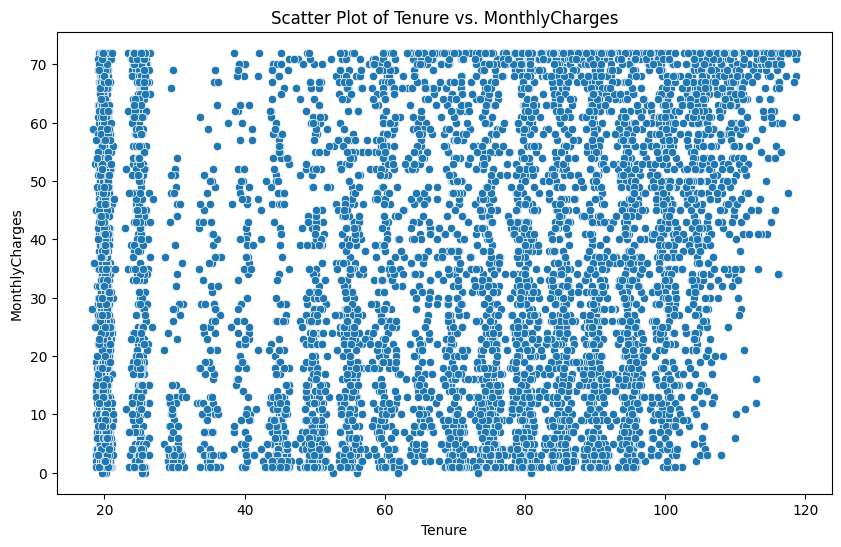

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='tenure', data=data)
plt.title('Scatter Plot of Tenure vs. MonthlyCharges')
plt.xlabel('Tenure')
plt.ylabel('MonthlyCharges')
plt.show()

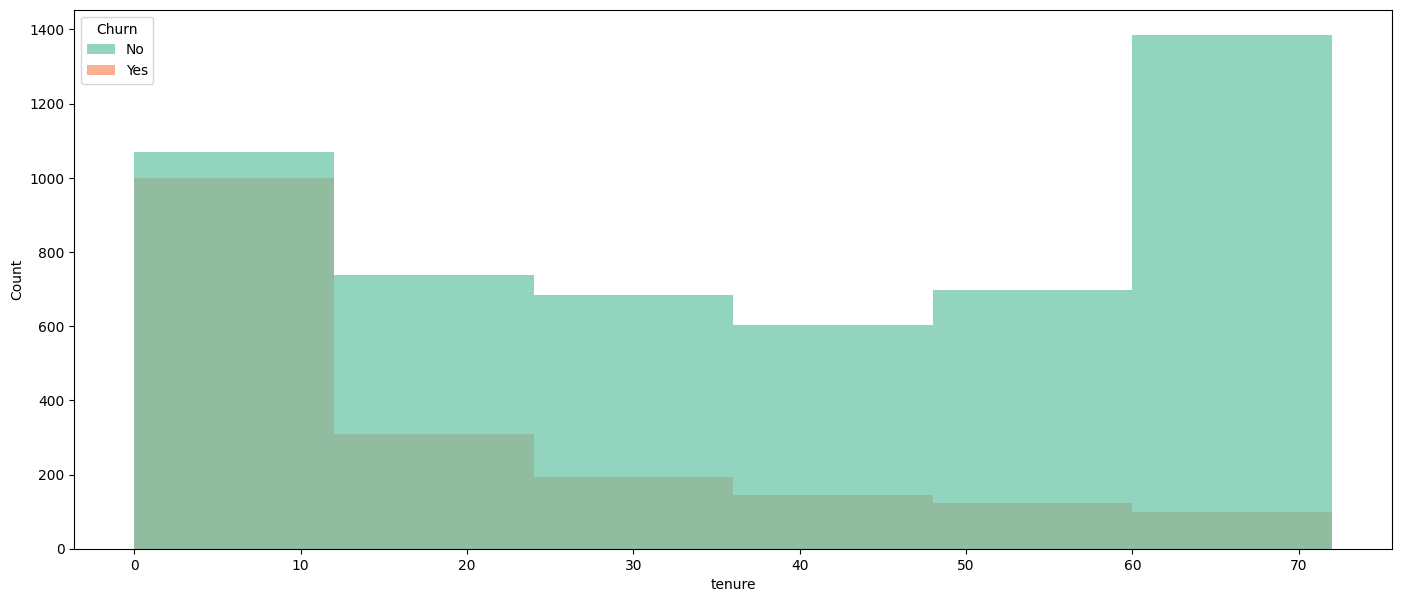

In [31]:
plt.figure(figsize=(17, 7))
sns.histplot(data=data, x="tenure", hue="Churn", palette="Set2", edgecolor='none', alpha=0.7, bins=6)
plt.xlabel('tenure')
plt.show()

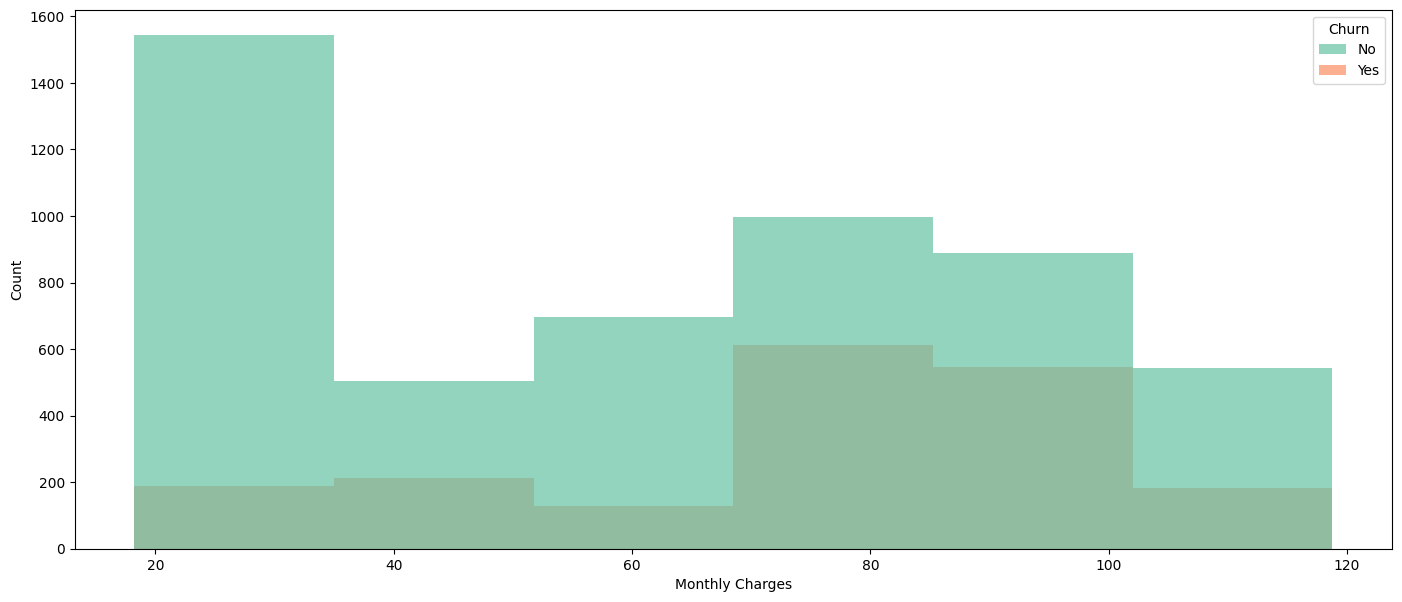

In [32]:
plt.figure(figsize=(17, 7))
sns.histplot(data=data, x="MonthlyCharges", hue="Churn", palette="Set2", edgecolor='none', alpha=0.7, bins=6)
plt.xlabel('Monthly Charges')
plt.show()

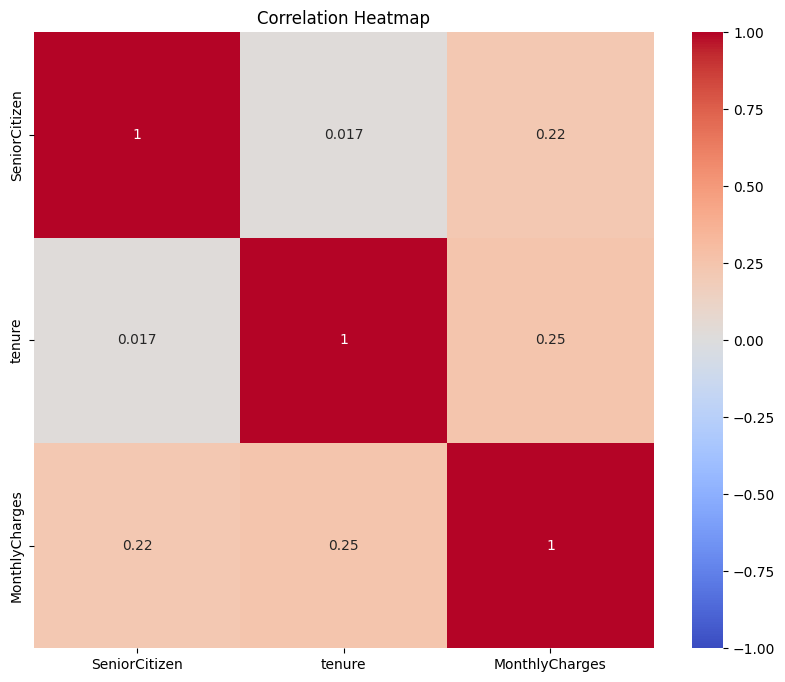

In [33]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[['SeniorCitizen', 'tenure', 'MonthlyCharges']].astype(float).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pre-Processing Operations :

##### Dropping Unuseful Columns 

In [34]:
data=data.drop(columns = "customerID")

##### Get the object Features values count

In [35]:
GetObjectFeatures(data)

gender
Male      3555
Female    3488
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64 

StreamingTV
No       

## Encoding Categorical Data 

##### Encoding Ordinal Based Features (Contract) :

In [36]:
CategoryOrder = ["Month-to-month", "One year", "Two year"]
encoder = OrdinalEncoder(categories=[CategoryOrder])
data["Contract"] = encoder.fit_transform(data[["Contract"]])

##### Convert Data type of Feature from string to float (TotalCharges) :

In [37]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors='coerce')
data["TotalCharges"] = data["TotalCharges"].astype(float)


##### Encoding Features with Label Encoder (All Except Contract ,TotalCharges) :

In [38]:
labelEncoderDf = data.drop(columns=["Contract", "TotalCharges"])
labelEncoderColumns = labelEncoderDf.columns
for col in labelEncoderColumns :
    data[col]=LabelEncoder().fit_transform(data[col])

##### Showing Data After Some Changes :

In [39]:
data

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 1                0               0             2   
1                 0                0               2             0   
2                 0                0               2             2   
3                 1                0               2             0   
4                 0                1               0             0   
...             ...              ...             ...           ...   
7038              2                0               2             0   
7039              2                1               0             2   
7040              1                0               2             0   
7041              2                1               0             0   
7042              0                1               2             0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    0            0            0                0       0.0   
1                    2            0            0                0       1.0   
2                    0            0            0                0       0.0   
3                    2            2            0                0       1.0   
4                    0            0            0                0       0.0   
...                ...          ...          ...              ...       ...   
7038                 2            2            2                2       1.0   
7039                 2            0            2                2       1.0   
7040                 0            0            0                0       0.0   
7041                 0            0            0                0       0.0   
7042                 2            2            2                2       2.0   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                    1              2             142         29.85      0  
1                    0              3             498       1889.50      0  
2                    1              3             436        108.15      1  
3                    0              0             266       1840.75      0  
4                    1              2             729        151.65      1  
...                ...            ...             ...           ...    ...  
7038                 1              3             991       1990.50      0  
7039                 1              1            1340       7362.90      0  
7040                 1              2             137        346.45      0  
7041                 1              3             795        306.60      1  
7042                 1              0            1388       6844.50      0  

[7043 rows x 20 columns]

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   float64
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [41]:
data.describe()

gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7043.000000  7043.000000  7043.000000  7043.000000   
mean      0.504756       0.162147     0.483033     0.299588    32.371149   
std       0.500013       0.368612     0.499748     0.458110    24.559481   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7043.000000    7043.000000      7043.000000     7043.000000   
mean       0.903166       0.940508         0.872923        0.790004   
std        0.295752       0.948554         0.737796        0.859848   
min        0.000000       0.000000         0.000000        0.000000   
25%        1.000000       0.000000         0.000000        0.000000   
50%        1.000000       1.000000         1.000000        1.000000   
75%        1.000000       2.000000         1.000000        2.000000   
max        1.000000       2.000000         2.000000        2.000000   

       OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
count   7043.000000       7043.000000  7043.000000  7043.000000   
mean       0.906432          0.904444     0.797104     0.985376   
std        0.880162          0.879949     0.861551     0.885002   
min        0.000000          0.000000     0.000000     0.000000   
25%        0.000000          0.000000     0.000000     0.000000   
50%        1.000000          1.000000     1.000000     1.000000   
75%        2.000000          2.000000     2.000000     2.000000   
max        2.000000          2.000000     2.000000     2.000000   

       StreamingMovies     Contract  PaperlessBilling  PaymentMethod  \
count      7043.000000  7043.000000       7043.000000    7043.000000   
mean          0.992475     0.690473          0.592219       1.574329   
std           0.885091     0.833755          0.491457       1.068104   
min           0.000000     0.000000          0.000000       0.000000   
25%           0.000000     0.000000          0.000000       1.000000   
50%           1.000000     0.000000          1.000000       2.000000   
75%           2.000000     1.000000          1.000000       2.000000   
max           2.000000     2.000000          1.000000       3.000000   

       MonthlyCharges  TotalCharges        Churn  
count     7043.000000   7032.000000  7043.000000  
mean       683.524776   2283.300441     0.265370  
std        478.511521   2266.771362     0.441561  
min          0.000000     18.800000     0.000000  
25%        199.000000    401.450000     0.000000  
50%        722.000000   1397.475000     0.000000  
75%       1090.000000   3794.737500     1.000000  
max       1584.000000   8684.800000     1.000000

In [42]:
data.dropna(inplace=True)


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   float64
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  
 17  

## Scaling All Features 

#### The range of values is not great but going to scale it to make all features in the range of 0 to 1 with MinMaxScaler

In [44]:
AllColumns = data.columns
data[AllColumns]=MinMaxScaler().fit_transform(data[AllColumns])

##### Showing Data After Pre-Processing Operations :

In [45]:
data.describe()

gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7032.000000    7032.000000  7032.000000  7032.000000  7032.000000   
mean      0.504693       0.162400     0.482509     0.298493     0.442560   
std       0.500014       0.368844     0.499729     0.457629     0.345708   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     0.112676   
50%       1.000000       0.000000     0.000000     0.000000     0.394366   
75%       1.000000       0.000000     1.000000     1.000000     0.760563   
max       1.000000       1.000000     1.000000     1.000000     1.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7032.000000    7032.000000      7032.000000     7032.000000   
mean       0.903299       0.470279         0.436291        0.394625   
std        0.295571       0.474314         0.368636        0.429981   
min        0.000000       0.000000         0.000000        0.000000   
25%        1.000000       0.000000         0.000000        0.000000   
50%        1.000000       0.500000         0.500000        0.500000   
75%        1.000000       1.000000         0.500000        1.000000   
max        1.000000       1.000000         1.000000        1.000000   

       OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
count   7032.000000       7032.000000  7032.000000  7032.000000   
mean       0.452929          0.451934     0.398180     0.492463   
std        0.440197          0.440089     0.430837     0.442642   
min        0.000000          0.000000     0.000000     0.000000   
25%        0.000000          0.000000     0.000000     0.000000   
50%        0.500000          0.500000     0.500000     0.500000   
75%        1.000000          1.000000     1.000000     1.000000   
max        1.000000          1.000000     1.000000     1.000000   

       StreamingMovies     Contract  PaperlessBilling  PaymentMethod  \
count      7032.000000  7032.000000       7032.000000    7032.000000   
mean          0.496445     0.344283          0.592719       0.524412   
std           0.442692     0.416467          0.491363       0.355835   
min           0.000000     0.000000          0.000000       0.000000   
25%           0.000000     0.000000          0.000000       0.333333   
50%           0.500000     0.000000          1.000000       0.666667   
75%           1.000000     0.500000          1.000000       0.666667   
max           1.000000     1.000000          1.000000       1.000000   

       MonthlyCharges  TotalCharges        Churn  
count     7032.000000   7032.000000  7032.000000  
mean         0.431880      0.261309     0.265785  
std          0.302085      0.261571     0.441782  
min          0.000000      0.000000     0.000000  
25%          0.126736      0.044155     0.000000  
50%          0.455808      0.159090     0.000000  
75%          0.688289      0.435719     1.000000  
max          1.000000      1.000000     1.000000

## Saving the dataset after all pre-processing (Except All Splits)

In [76]:
data.to_csv('Encoded Data.csv', index=False)

## The first split  for the data to Features and Target 

In [46]:
X = data.drop(columns = "Churn")
Y = data ["Churn"]

## The second split to train and test groups 

In [47]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3,random_state=19)

# Appling Grid search model on models :

## Apply GridSearch on SVM Classifier and Evaluate it :

In [48]:
SVM_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'decision_function_shape':["ovo","ovr"],
    'verbose':[True , False]
    
}


SVM = svm.SVC()
GRS = GridSearchCV(SVM, SVM_params, cv=5)
GRS.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print(GRS.best_params_)
print(GRS.best_score_)

[LibSVM].
*
optimization finished, #iter = 1809
obj = -187.785396, rho = -0.539742
nSV = 1932, nBSV = 1911
Total nSV = 1932
[LibSVM].
*
optimization finished, #iter = 1630
obj = -192.982955, rho = -0.714705
nSV = 1982, nBSV = 1965
Total nSV = 1982
[LibSVM].
*
optimization finished, #iter = 1641
obj = -187.555245, rho = -0.454957
nSV = 1932, nBSV = 1913
Total nSV = 1932
[LibSVM].
*
optimization finished, #iter = 1801
obj = -192.151888, rho = -0.477718
nSV = 1977, nBSV = 1956
Total nSV = 1977
[LibSVM].
*
optimization finished, #iter = 1982
obj = -192.721323, rho = -0.468928
nSV = 1983, nBSV = 1962
Total nSV = 1983
[LibSVM].
*
optimization finished, #iter = 1364
obj = -187.990512, rho = -0.805395
nSV = 2058, nBSV = 1949
Total nSV = 2058
[LibSVM].
*
optimization finished, #iter = 1390
obj = -193.289970, rho = -0.803368
nSV = 2114, nBSV = 1997
Total nSV = 2114
[LibSVM].
*
optimization finished, #iter = 1282
obj = -189.311087, rho = -0.800350
nSV = 2072, nBSV = 1978
Total nSV = 2072
[LibSVM]

##### The output of the GridSearch Model and Best Parameters :
{'C': 0.1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'verbose': True}

0.7954124881350336

nSV = 2432, nBSV = 2410

Total nSV = 2432

[LibSVM].
*.*
optimization finished, #iter = 2145
obj = -237.479232, rho = -0.525993
nSV = 2432, nBSV = 2410
Total nSV = 2432
SVM Model Accuracy: 0.8052132701421801
[[1405  146]
 [ 265  294]]


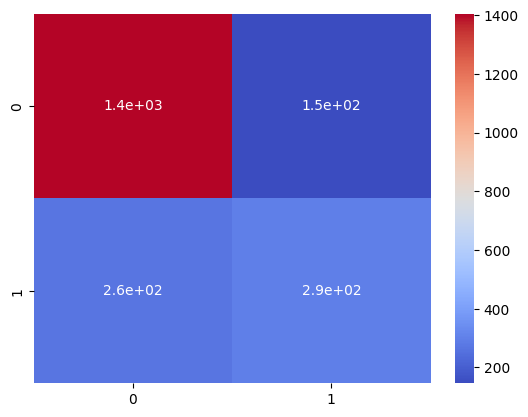

Precision: 0.7954
Recall: 0.8052
F1-Score: 0.7972
ROC-AUC: 0.7159


Classification Report for SVM Model:

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1551
         1.0       0.67      0.53      0.59       559

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110


------------------------------------------------------------



In [67]:
SVM_Model=svm.SVC(C=0.1,decision_function_shape="ovo",degree=2,gamma="scale",kernel="linear",verbose=True)
TrainEvaluateModel(Xtrain, Ytrain, Xtest, Ytest , {"SVM Model":SVM_Model})

## Apply GridSearch on Gradient Boosting Classifier and Evaluate it :

In [52]:
GB_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}


GB = GradientBoostingClassifier()
GB_GRS = GridSearchCV(GB, GB_params, cv=5)
GB_GRS.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Gradient Boosting Best Parameters:", GB_GRS.best_params_)
print("Gradient Boosting Best Score:", GB_GRS.best_score_)

Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Gradient Boosting Best Score: 0.8000835706326607


Gradient Boost Model Accuracy: 0.8132701421800947
[[1424  127]
 [ 267  292]]


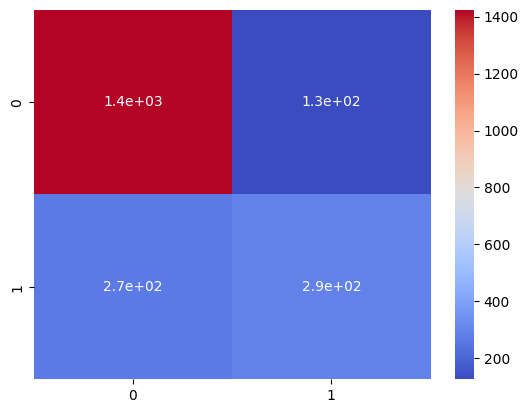

Precision: 0.8036
Recall: 0.8133
F1-Score: 0.8039
ROC-AUC: 0.7202


Classification Report for Gradient Boost Model:

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      1551
         1.0       0.70      0.52      0.60       559

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110


------------------------------------------------------------



In [66]:
GB_Model=GradientBoostingClassifier(learning_rate=0.1,max_depth=3,n_estimators=50,subsample=0.8)
TrainEvaluateModel(Xtrain, Ytrain, Xtest, Ytest , {"Gradient Boost Model":GB_Model})

## Apply GridSearch on XGBoost Classifier and Evaluate it :

In [55]:
XGB_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


XGB = xgb.XGBClassifier()
XGB_GRS = GridSearchCV(XGB, XGB_params, cv=5)
XGB_GRS.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("XGBoost Best Parameters:", XGB_GRS.best_params_)
print("XGBoost Best Score:", XGB_GRS.best_score_)

XGBoost Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
XGBoost Best Score: 0.8013018447443357


XGBoost Model Accuracy: 0.8037914691943128
[[1401  150]
 [ 264  295]]


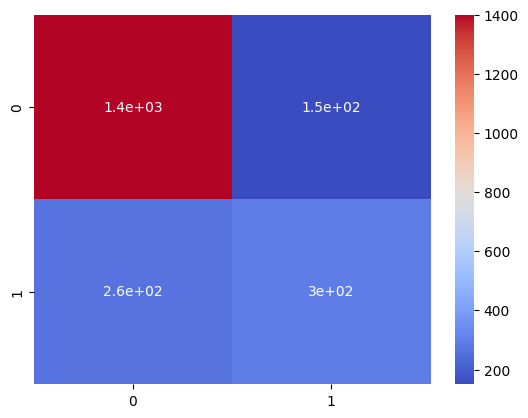

Precision: 0.7941
Recall: 0.8038
F1-Score: 0.7961
ROC-AUC: 0.7155


Classification Report for XGBoost Model:

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1551
         1.0       0.66      0.53      0.59       559

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110


------------------------------------------------------------



In [65]:
XGB_Model=xgb.XGBClassifier(colsample_bytree=0.8,learning_rate=0.1,max_depth=5,n_estimators=50,subsample=1.0)
TrainEvaluateModel(Xtrain, Ytrain, Xtest, Ytest , {"XGBoost Model":XGB_Model})

## Apply GridSearch on Voting Classifier and Evaluate it :

In [61]:
voting_params = {'voting': ['hard', 'soft']  }

voting_clf = VotingClassifier(estimators=[
    ('SVM', SVM),
    ('GradientBoost', GB),
    ('XGBoost', XGB)
])

voting_GRS = GridSearchCV(voting_clf, voting_params, cv=5)
voting_GRS.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Voting Classifier Best Parameters:", voting_GRS.best_params_)
print("Voting Classifier Best Score:", voting_GRS.best_score_)

Voting Classifier Best Parameters: {'voting': 'hard'}
Voting Classifier Best Score: 0.7982559531179068


[LibSVM].
*.*
optimization finished, #iter = 2145
obj = -237.479232, rho = -0.525993
nSV = 2432, nBSV = 2410
Total nSV = 2432
Voting Classifier Model Accuracy: 0.8090047393364929
[[1415  136]
 [ 267  292]]


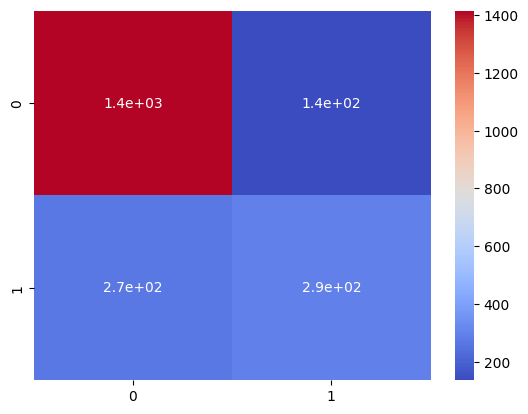

Precision: 0.7991
Recall: 0.8090
F1-Score: 0.8002
ROC-AUC: 0.7173


Classification Report for Voting Classifier Model:

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88      1551
         1.0       0.68      0.52      0.59       559

    accuracy                           0.81      2110
   macro avg       0.76      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110


------------------------------------------------------------



In [69]:
Voting_Model=VotingClassifier(estimators=[
    ('SVM', SVM_Model),
    ('GradientBoost', GB_Model),
    ('XGBoost', XGB_Model)
],voting="hard")
TrainEvaluateModel(Xtrain, Ytrain, Xtest, Ytest , {"Voting Classifier Model":Voting_Model})

# Additional Analysis :

In [72]:
models={"SVM_Model":SVM_Model,"Gradient Boosting Model":GB_Model,"XGBoost Model":XGB_Model,"Voting Classifier Model":Voting_Model}

## Plot for Features Importance 

[LibSVM]..
*.*
optimization finished, #iter = 3265
obj = -331.496522, rho = -0.390035
nSV = 3380, nBSV = 3358
Total nSV = 3380
[LibSVM]..
*.*
optimization finished, #iter = 3265
obj = -331.496522, rho = -0.390035
nSV = 3380, nBSV = 3358
Total nSV = 3380


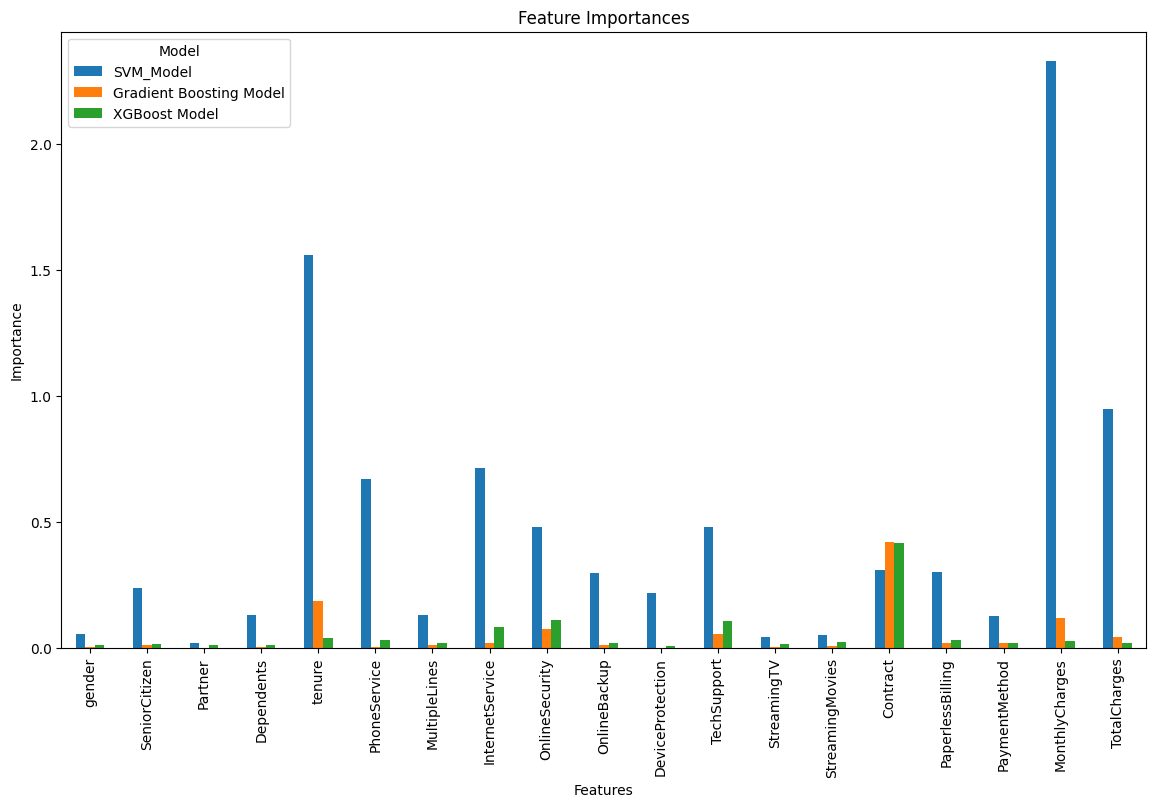

In [73]:
PlotFeaturesImportance(X,Y,models)

## Report About Features Importance 

Key Observations:
Feature Dominance: The feature "TotalCharges" stands out with significant importance in the Gradient Boosting and XGBoost models, indicating a strong correlation with the target variable. It's less significant in the SVM model, likely due to the different nature of the algorithm.
SVM Model: The SVM model shows generally low feature importance across the board, which might be due to its sensitivity to scale and the type of kernel used.
Gradient Boosting Model: Shows varied importance across features, with "tenure" and "TotalCharges" being particularly prominent. This indicates that these features play a crucial role in the model's decision-making process.
XGBoost Model: Like Gradient Boosting, XGBoost also highlights "tenure" and "TotalCharges" as important features, but with even greater emphasis on "TotalCharges."
Insights:
Critical Features:

TotalCharges: Both tree-based models consider this the most influential feature, suggesting that customer billing amount is a decisive factor in predicting the outcome.
Tenure: Another significant feature for the tree-based models, suggesting the length of customer relationship has a considerable impact on model predictions.
Less Influential Features:

Features like "gender," "SeniorCitizen," "Partner," and various service types (e.g., "PhoneService," "OnlineSecurity") show minimal impact on the model predictions across all three models. This might suggest that these factors are less critical in influencing the target variable.
Model-Specific Characteristics:

XGBoost and Gradient Boosting: These models are able to capture non-linear relationships and interactions between features, which is likely why they show a more varied distribution of feature importance.
SVM: The linear nature (assuming a linear kernel was used based on the chart) of SVM might be less effective at capturing complex patterns in large and diverse datasets, reflected in the low overall feature importances.
Conclusion:
The graph is crucial for understanding which features are most impactful in predicting the target variable according to each model. This knowledge can guide feature engineering and selection in future model iterations to improve performance and efficiency. Decision-makers might focus on "TotalCharges" and "tenure" for interventions or further analysis, while potentially deprioritizing features that consistently show low importance across models.

## Plot for Training and Validation Scores 

[LibSVM].
*.*
optimization finished, #iter = 2145
obj = -237.479232, rho = -0.525993
nSV = 2432, nBSV = 2410
Total nSV = 2432
[LibSVM].
*.*
optimization finished, #iter = 2145
obj = -237.479232, rho = -0.525993
nSV = 2432, nBSV = 2410
Total nSV = 2432


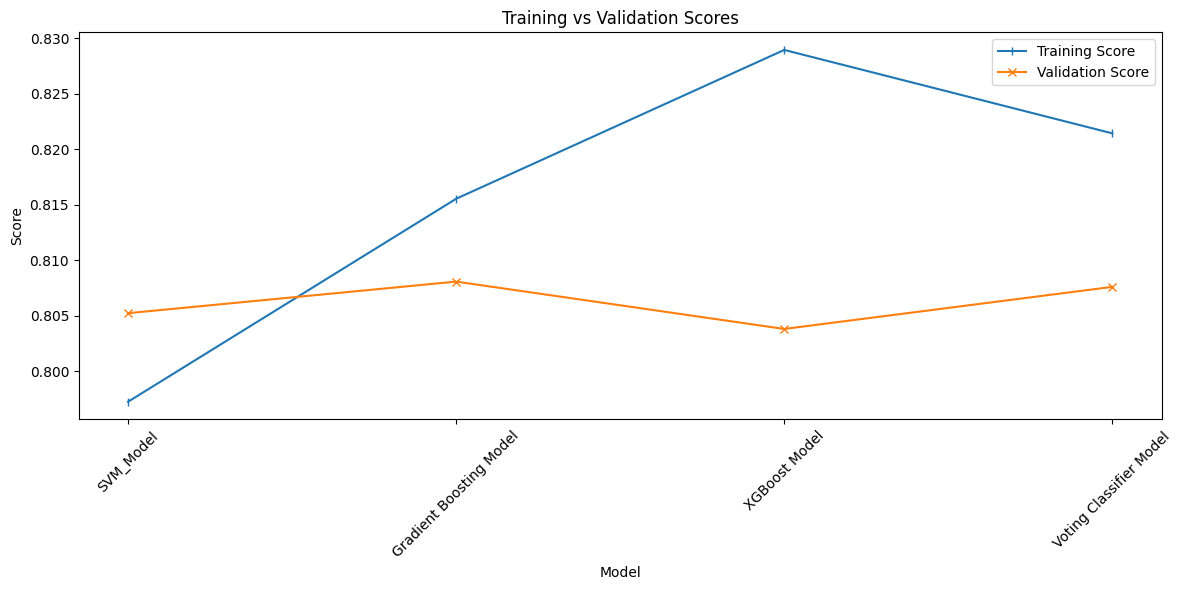

In [74]:
PlotOverfitting(models,Xtrain,Xtest,Ytrain,Ytest)

## Report About Training and Validation Scores 

Report:
The graph illustrates a comparative performance analysis of four different machine learning models. Here's a breakdown of the observations and implications:

SVM Model: Shows a steady increase in performance from the training to validation context. The consistency in scores suggests that the model generalizes well but starts from a lower baseline of accuracy.

Gradient Boosting Model: Demonstrates a significant improvement in training scores but a relatively flat trend in validation scores. This may indicate overfitting as the model performs well on the training data but fails to generalize these results to new, unseen data.

XGBoost Model: Exhibits the highest training scores, indicating strong learning on the training set. However, there is a decline in the validation score towards the end, suggesting potential overfitting issues.

Voting Classifier Model: This ensemble method shows the least variation between training and validation scores, which are both relatively low compared to other models. This could mean that while the model is stable, it may not be capturing all the complexities in the data, or it might need better tuning of its constituent models.

Overall, the differences in training and validation scores across these models provide insights into their robustness and generalization capabilities. It's evident that while ensemble methods like the Voting Classifier offer stability, models like XGBoost can achieve higher accuracy but might require careful tuning to prevent overfitting. The choice of model would depend on the specific needs for accuracy versus generalizability in a real-world application.

# Saving Models :

In [75]:
SaveModels(models)

Model 'SVM_Model' saved as 'Models - SVM_Model.sav'.
Model 'Gradient Boosting Model' saved as 'Models - Gradient Boosting Model.sav'.
Model 'XGBoost Model' saved as 'Models - XGBoost Model.sav'.
Model 'Voting Classifier Model' saved as 'Models - Voting Classifier Model.sav'.


# The Final report to choose the final model :

### Comprehensive Evaluation of Machine Learning Models

Let’s delve into the performance of the SVM, XGBoost, and Gradient Boosting models using the provided metrics and classification reports to identify the most suitable model for the task at hand.

#### SVM Model:
- **Accuracy:** 80.52%
- **Precision (Overall):** 79.54%
- **Recall (Overall):** 80.52%
- **F1-Score (Overall):** 79.72%
- **ROC-AUC:** 71.59%
- **Performance on Class 0 (Negative):**
  - **Precision:** 84%
  - **Recall:** 91%
  - **F1-Score:** 87%
- **Performance on Class 1 (Positive):**
  - **Precision:** 67%
  - **Recall:** 53%
  - **F1-Score:** 59%

#### XGBoost Model:
- **Accuracy:** 80.38%
- **Precision (Overall):** 79.41%
- **Recall (Overall):** 80.38%
- **F1-Score (Overall):** 79.61%
- **ROC-AUC:** 71.55%
- **Performance on Class 0 (Negative):**
  - **Precision:** 84%
  - **Recall:** 90%
  - **F1-Score:** 87%
- **Performance on Class 1 (Positive):**
  - **Precision:** 66%
  - **Recall:** 53%
  - **F1-Score:** 59%

#### Gradient Boost Model:
- **Accuracy:** 81.33%
- **Precision (Overall):** 80.36%
- **Recall (Overall):** 81.33%
- **F1-Score (Overall):** 80.39%
- **ROC-AUC:** 72.02%
- **Performance on Class 0 (Negative):**
  - **Precision:** 84%
  - **Recall:** 92%
  - **F1-Score:** 88%
- **Performance on Class 1 (Positive):**
  - **Precision:** 70%
  - **Recall:** 52%
  - **F1-Score:** 60%

### Analysis and Recommendations

**Gradient Boosting Model** emerges as the leader across several key metrics:
- It offers the highest accuracy and ROC-AUC score among the models, suggesting better overall performance and ability to distinguish between classes.
- Its precision and F1-score are notably higher for Class 1, indicating a better balance in recognizing both classes compared to SVM and XGBoost.
- The model shows less disparity between training and validation performance, which implies better generalization from training to unseen data.

**SVM and XGBoost** models show similar performances but slightly trail behind Gradient Boosting, especially in the ROC-AUC and precision for Class 1. While they are competitive, they fall short in certain critical areas, notably in capturing the nuances of the positive class effectively.

### Conclusion

Given the comparative analysis, the **Gradient Boosting Model** is recommended as the final model for deployment. It not only performs well in terms of accuracy and ROC-AUC but also demonstrates a commendable balance across precision, recall, and F1-score, crucial for a holistic model evaluation. It effectively handles the complexities inherent in the data, making it a robust choice for predictive tasks requiring discernment between classes with potentially varying levels of impact.